In [244]:
import sklearn
from sklearn import model_selection, feature_selection
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from log_regression import test, DPLogisticRegression
from ChoiceMaker import ChoiceMaker, DTChoice
import graphviz
import seaborn as sns
import copy
%matplotlib inline

In [50]:
import pickle
"""Method for loading or running a function (if it doesn't exist) located in the metadata folder"""
def load_or_run(name, f):
    name = 'log_regression_metadata/' + name
    try:
        r = pickle.load(open(name, 'rb'))
    except:
        r = f()
        pickle.dump(r, open(name, 'wb'))
    return r

### Data Generation Methods

In [51]:
#train_set
#def gen_binary_data(domain, nrow, seed):
ncol = 7
nrow = 1000
seed=12345
y_ratio=0.4
def gen_data(low, high, ncol, nrow, y_ratio, seed=12345, prng=None):
    """Generates an array containing a binary output and inputs drawn 
    from Gaussians. The output is the last column of the array
    and the inputs are the other columns. The inputs are conditionally
    independent of each other given the output. Thus, input at column i
    for output value j are drawn from a normal with mean mu_ij and 
    sigma_ij. Furthermore, we force sigma_ij = sigma_i with no dependence
    on j because this assumption allows us to derive logistic regression
    as the best fitting algorithm. We draw sigma_i and mu_ij randomly.
    We ensure sigma_i is at most one-quarter of high-low to ensure the
    Gaussian will mostly fit in the [low, high] interval.
    
    Parameters
    ----------

    low: lower bound on an input value
    
    high: upper bound on an input value
    
    ncol: number of inputs of the dataset
    
    nrow: number of rows in the dataset
    
    y_ratio: fraction of rows that take value 0 on the output column
    
    seed: seed value to use. Default: 12345
    
    prng: random number generator. One of seed or prng must not be None. 
    """
    if(prng == None):
        prng = np.random.RandomState(seed)
    sigmas = prng.uniform(0, (high-low)/6, ncol)
    s1 = int(y_ratio*nrow)
    s2 = nrow-s1
    def gen_col(sigma, sz):
        mu = prng.uniform(low+3*sigma, high-3*sigma)
        ans = prng.normal(mu, sigma, sz)
        c = (ans < low).sum()
        while(c > 0):
            ans[ans < low] = prng.normal(mu, sigma, c)
            c = (ans < low).sum()
        c = (ans > high).sum()
        while(c > 0):
            ans[ans > high] = prng.normal(mu, sigma, c)
            c = (ans > high).sum()
        return ans
    P1 = np.array([gen_col(s, s1) for s in sigmas] + [np.zeros(s1)]).T
    P2 = np.array([gen_col(s, s2) for s in sigmas] + [np.ones(s2)]).T
    A = np.concatenate((P1, P2))
    return A[np.random.permutation(len(A))]

In [92]:
def reshape_dset(db, ncol, nrow, y_ratio, seed=12345, prng=None):
    """Rescales an input database to the desired parameters.
    Parameters
    ----------
    db: Input array. We assume last row is the output row.
        The output row must be binary.
        
    ncol: Desired number of columns in output.
    
    nrow: Desired number of rows.
    
    y_ratio: Desired percentage of class 2 in the output
    
    seed: seed value to use. Default: 12345
    
    prng: random number generator. One of seed or prng must not be None. 
    """
    if(prng == None):
        prng = np.random.RandomState(seed)
    ys = db[db.columns[-1]]
    v1, v2 = ys.unique()[:2]
    Z1 = db[ys == v1]
    s1 = int(y_ratio*nrow)
    Z2 = db[ys == v2]
    s2 = nrow - s1
    def reshape(Z, nrow):
        db = pd.DataFrame()
        while db.shape[0] + Z.shape[0] < nrow:
            db = pd.concat((db, Z), ignore_index=True)
        return pd.concat((db, Z.sample(nrow - db.shape[0])), ignore_index=True)
    db = pd.concat((reshape(Z1, s1), reshape(Z2, s2)), ignore_index=True)
    db_x = db[db.columns[:-1]]
    ys = db[db.columns[-1]]
    db = pd.DataFrame()
    while db.shape[1] + db_x.shape[1] < ncol:
        db = pd.concat((db, db_x), axis=1, ignore_index=True)
    rand_cols = np.random.choice(db_x.columns, ncol-db.shape[1], replace=False)
    return pd.concat((db, db_x[rand_cols], ys), axis=1, ignore_index=True)

### ChoiceMaker Classes

In [133]:
#TODO: Change this to sklearn.model_selection.KFold
def manual_CV(db, parts, clf):
    """Does cross-validation on the dataframe."""
    A = np.linspace(0, len(db.X), parts+1).astype(int)
    arr = []
    for train_idx, test_idx in kf.split(db.X):
        X_test = db.X.iloc[test_idx]
        y_test = db.y.iloc[test_idx]
        X_train = db.X.iloc[train_idx]
        y_train = db.y.iloc[train_idx]
        #Have to fix case when only one class exists
        if len(np.unique(y_train)) == 1:
            score = (y_train == y_train.iloc[0]).sum() / len(y_train)
            arr.append(score)
        else:
            clf.fit(X_train, y_train)
            arr.append(clf.score(X_test, y_test))
    return np.array(arr)

In [132]:
#alg_list
class DP:
    def __init__(self, C):
        self.name = str(C)
        self.epsilon=0.1
        self.model = DPLogisticRegression(self.epsilon, C=C, K=1.02, fit_intercept=True)
    def error(self, db):
        A = manual_CV(db, 5, self.model)
        return 1.0-A.mean()
    def run(self, db):
        self.model.set_epsilon(db.epsilon)
        return self.model.fit(db.X, db.y)

In [7]:
class DB:
    def __init__(self, X, y, epsilon=1):
        self.epsilon = epsilon
        self.ncol = X.shape[1]
        self.X = pd.get_dummies(X)
        self.y = y

In [8]:
class DBMetafeatures:
    def __init__(self):
        self.sensitivities = {'nrow': 0, 'ncol': 0, 'eps': 0, 'numy': 1}
    
    def __call__(self, dataset):
        return {'nrow': dataset.X.shape[0], 
                'ncol': dataset.ncol,
                'eps': dataset.epsilon, 
                'numy': dataset.y.sum()}

In [134]:
#Generating Tset methods
def gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, reps=3, db=None, prng=None):
    """Generates a database for each member of the cross product of the arguments
    
    Params:
    db: "Real database" to perform surgery on. If None, then synthetic database.
    """
    for c in col_vals:
        for r in row_vals:
            for e in eps_vals:
                for ratio in ratios:
                    for x in range(0, reps):
                        if db is None:
                            G = pd.DataFrame(gen_data(low=0, high=1, ncol=c, nrow=r, y_ratio=ratio, prng=prng))
                        else:
                            G = reshape_dset(db, ncol=c, nrow=r, y_ratio=ratio, prng=prng)
                        last_name = G.columns[-1]
                        yield DB(G.drop([last_name], axis=1), G[last_name], e)
            
#G = gen_tset_size_range(4, [0.2, 0.4, 0.6, 0.8, 1.0], np.arange(20, 200, 20))

### Adult Dataset Preprocessing

In [136]:
adult = pd.read_csv('data/adult.data', header=None)
adult = adult.rename(columns = {0: 'age', 1: 'workclass', 2: 'fnlwgt', 3: 'education', 
                                4: 'education_num', 5: 'marital_status', 6: 'occupation',
                                7: 'relationship', 8: 'race', 9: 'sex', 10: 'captial_gain',
                                11: 'captial_loss', 12: 'hours-per-week', 13: 'native_country', 14: 'TARGET'})
adult = adult.drop('education', axis=1)

In [137]:
le = LabelEncoder()
adult['TARGET'] = le.fit_transform(adult['TARGET'])

In [138]:
#adult_cm = load_or_run('adult_cm.p', lambda: DTChoice(adult_data, DBMetafeatures(), {a.name: a for a in alg_list}, reps=1))

### Credit Default Dataset Preprocessing

In [139]:
default = pd.read_csv('data/application_train.csv')
default['TARGET'] = le.fit_transform(default['TARGET'])

In [140]:
#C = default.corr()
#default = default[abs(C['TARGET']).sort_values().index[-30:]].sample(10000)

In [141]:
#For simplicity, get rid of all columns with missing data
default = default[default.columns[default.notnull().all()]].sample(10000)

In [142]:
#Put target at end
new_cols = list(default.columns)
new_cols[1] = new_cols[-1]
new_cols[-1] = 'TARGET'
default = default[new_cols]

In [143]:
#default_cm = load_or_run('default_cm.p', lambda: DTChoice(default_data, DBMetafeatures(), {a.name: a for a in alg_list}, reps=1))

### Lending Dataset Preprocessing

In [147]:
lending = pd.read_csv('data/fam_credit_ss.csv')

In [148]:
#Swap first and last column
L = list(lending.columns)
L[0] = L[-1]
L[-1] = 'credit_card'
lending = lending[L]

In [149]:
#Some columns should be changed to object
lending.select_dtypes(['int64']).apply(pd.Series.nunique)

social_security       4
stud_loan             4
medical_exp           4
income             5963
marital_status        6
auto_insurance      712
children             10
age                  85
gender                2
housing               3
health_status         7
work_hours           93
credit_card           2
dtype: int64

In [150]:
unordered_cols = ['social_security', 'stud_loan', 'medical_exp', 'marital_status', 'housing', 'health_status']
lending[unordered_cols] = lending[unordered_cols].astype('object')

In [151]:
#lending_cm = load_or_run('lending_cm.p', lambda: DTChoice(lending_data, DBMetafeatures(), {a.name: a for a in alg_list}, reps=1))

### Data analysis

In [152]:
prng = np.random.RandomState(12345)
eps_vals = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2]
col_vals = np.arange(2, 20, 2)
row_vals = [20, 40, 100, 150, 300, 600, 1000, 2000, 3000]
ratios = [0.15, 0.3, 0.5, 0.7, 0.85]
num_reps = 3
alg_list = [DP(C=x) for x in [0.1, 0.5, 1.0, 1.5, 2]]
def split_db(db, prng=None):
    return gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, num_reps, db, prng)

In [156]:
#Database Generation:
#Unfortunately, these have to be lists, not generators
adult_data = list(split_db(adult, prng))
default_data = list(split_db(default, prng))
lending_data = list(split_db(lending, prng))

In [160]:
def get_cm(db):
    return DTChoice(db, DBMetafeatures(), {a.name: a for a in alg_list}, reps=1)
from multiprocessing import Pool
pool = Pool(processes=3)
cms = pool.map(get_cm, [adult_data, default_data, lending_data])

Process ForkPoolWorker-6:
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/hom

In [170]:

adult_cm = cms[0]
default_cm = cms[1]
lending_cm = cms[2]

In [166]:
#Experiment 1: Test the adult data and the lending data's prediction power on default data.
#Trials are cached within lending and adult data
adult_test_cm = DTChoice(adult_data + lending_data, DBMetafeatures(), 
                       {a.name: a for a in alg_list}, 1,
                       pd.concat((adult_cm.y, lending_cm.y)))

In [282]:
default_test_cm = adult_test_cm

In [167]:
L = [default_test_cm.get_regret(x) for x in default_data]
L = pd.concat(L)

In [175]:
#Let's try to improve this.
L.mean(axis=0)

0.1    0.101310
0.5    0.119553
1.0    0.135860
1.5    0.145728
2      0.151875
cm     0.102204
dtype: float64

In [283]:
algs = [default_test_cm.get_best_alg(x, 0.1) for x in default_data]

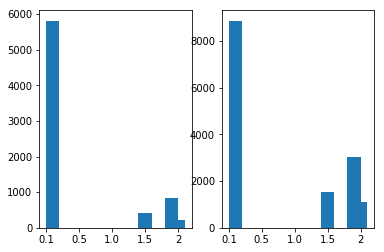

In [291]:
#0.1 is almost always being predicted, but true performances are more varied.
plt.subplot(121)
_ = plt.hist(algs)
plt.subplot(122)
_ = plt.hist(default_test_cm.y.idxmin(axis=1))

<Container object of 5 artists>

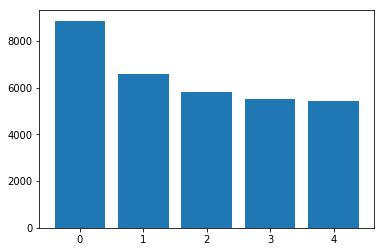

In [293]:
"""More pressingly, all the algorithms we try to predict perform about the same,
but we ask our Decision Tree to discriminate 0.1. So we should fix this first"""
plt.bar(np.arange(0, 5), [sum(C.min(axis=1) == C[col]) for col in C.columns])

In [208]:
#When we fix the above problem, this might improve our result
class DBMetafeatures:
    def __init__(self):
        A = {'nrow': 0, 'ncol': 0, 'eps': 0, 'numy': 1}
        B = A.copy()
        for a, b in A.items():
            start = False
            for c, d in A.items():
                if start:
                    B[a + '*' + c] = max(b, d)
                    B[a + '/' + c] = max(b, d)
                if a == c:
                    start = True
        self.sensitivities = B
    def __call__(self, dataset):
        A = {'nrow': dataset.X.shape[0], 
                'ncol': dataset.ncol,
                'eps': dataset.epsilon, 
                'numy': dataset.y.sum()}
        B = A.copy()
        for a, b in A.items():
            start = False
            for c, d in A.items():
                if start:
                    B[a + '*' + c] = b*d
                    B[a + '/' + c] = b/d
                if a == c:
                    start = True
        return B

In [272]:
adult_test_cm2 = DTChoice(adult_data + lending_data, DBMetafeatures(), 
                       {a.name: a for a in alg_list}, 1,
                       pd.concat((adult_cm.y, lending_cm.y)))

In [277]:
#L2 = [adult_test_cm3.get_regret(x) for x in default_data]
#L2 = pd.concat(L2)
L2.mean(axis=0)

0.1    0.099475
0.5    0.120440
1.0    0.135369
1.5    0.142109
2      0.149472
cm     0.101831
dtype: float64

In [274]:
algs = [adult_test_cm2.get_best_alg(x, 0.1) for x in default_data]

In [ ]:
#Model Problem: We are always predicting algorithm 1 due to the high 

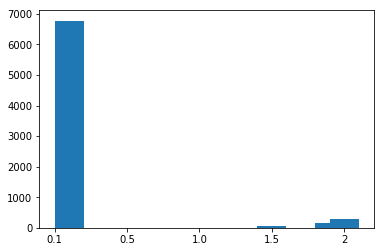

In [276]:
_ = plt.hist(algs)

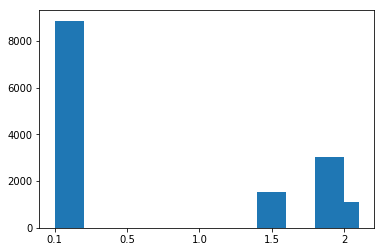

In [245]:
_ = plt.hist(adult_test_cm3.y.idxmin(axis=1))

In [281]:
C = adult_test_cm2.y
[sum(C.min(axis=1) == C[col]) for col in C.columns]

[8865, 6594, 5794, 5524, 5445]

In [267]:
len(C)

14580

In [142]:
dot_data = sklearn.tree.export_graphviz(adult_cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Synthetic database

In [23]:
cm = DTChoice(train_set, DBMetafeatures(), {a.name: a for a in alg_list}, reps=1)

In [23]:
#Variance calculation
cm.regrets.std(axis=0)

0.1    0.083701
0.5    0.050298
1.0    0.067889
1.5    0.074992
2      0.082567
dtype: float64

In [29]:
cm.regrets.mean(axis=0)

0.1    0.064082
0.5    0.030071
1.0    0.033723
1.5    0.039092
2      0.046795
dtype: float64

In [55]:
data = pd.concat([cm.X, cm.regrets], axis=1)
D = data.groupby(list(cm.X.columns))

In [63]:
A = np.array(D.mean())

In [64]:
B = np.array(D.std())

In [67]:
D.mean()

0.1       0.5       1.0       1.5         2
eps ncol nrow numy                                                    
0.2 2    40   6.0     0.003333  0.075000  0.155000  0.228333  0.266667
              12.0    0.006667  0.076667  0.098333  0.125000  0.160000
              20.0    0.091667  0.031667  0.030000  0.075000  0.058333
              28.0    0.005000  0.021667  0.103333  0.128333  0.110000
              34.0    0.000000  0.096667  0.155000  0.166667  0.180000
         80   12.0    0.025833  0.024167  0.070000  0.058333  0.117500
              24.0    0.060000  0.035000  0.083333  0.078333  0.110000
              40.0    0.080833  0.072500  0.042500  0.073333  0.043333
              56.0    0.096667  0.066667  0.039167  0.081667  0.070833
              68.0    0.005833  0.019167  0.072500  0.091667  0.087500
         200  30.0    0.059667  0.019667  0.005000  0.001667  0.009667
              60.0    0.154000  0.083000  0.036000  0.025667  0.015000
              100.0   0.126667  0.016333  0.032333  0.028000  0.070667
              140.0   0.189667  0.048333  0.044000  0.009000  0.009333
              170.0   0.050000  0.047333  0.019333  0.008667  0.002000
         300  45.0    0.040222  0.040222  0.035333  0.013111  0.000222
              90.0    0.241111  0.060889  0.035333  0.011333  0.003778
              150.0   0.115778  0.040222  0.019333  0.008444  0.017111
              210.0   0.190222  0.040000  0.007778  0.003111  0.005333
              255.0   0.035778  0.033333  0.015333  0.016889  0.003778
         600  90.0    0.060333  0.034111  0.022667  0.012444  0.000000
              180.0   0.189556  0.106333  0.025000  0.008667  0.000333
              300.0   0.025000  0.000000  0.003889  0.008111  0.004333
              420.0   0.112222  0.034889  0.010556  0.003333  0.003333
              510.0   0.074000  0.051778  0.024111  0.009444  0.000000
         1200 180.0   0.045500  0.019278  0.006500  0.002000  0.000000
              360.0   0.139111  0.030333  0.007889  0.003056  0.000000
              600.0   0.027278  0.006111  0.001056  0.001722  0.002500
              840.0   0.194167  0.068667  0.023389  0.009333  0.000000
              1020.0  0.082278  0.008778  0.001333  0.000056  0.000056
...                        ...       ...       ...       ...       ...
    18   300  45.0    0.099778  0.074889  0.014889  0.008889  0.040000
              90.0    0.250667  0.016444  0.009111  0.025778  0.082667
              150.0   0.000444  0.000000  0.014889  0.047556  0.067111
              210.0   0.239778  0.043333  0.032667  0.008889  0.076222
              255.0   0.106444  0.057111  0.008667  0.009333  0.030889
         600  90.0    0.149000  0.020778  0.001000  0.003222  0.003444
              180.0   0.191333  0.000000  0.000000  0.002444  0.003889
              300.0   0.000000  0.000000  0.000111  0.000778  0.001444
              420.0   0.205222  0.001000  0.000111  0.002889  0.004556
              510.0   0.148667  0.035556  0.007111  0.002000  0.004667
         1200 180.0   0.126500  0.015500  0.003000  0.000167  0.000000
              360.0   0.000278  0.000000  0.000000  0.000000  0.000000
              600.0   0.000000  0.000000  0.000000  0.000000  0.000000
              840.0   0.001611  0.000000  0.000000  0.000000  0.000000
              1020.0  0.146056  0.010111  0.000778  0.000389  0.000000
         2000 300.0   0.092367  0.012367  0.001300  0.000100  0.000000
              600.0   0.000067  0.000000  0.000000  0.000000  0.000000
              1000.0  0.000667  0.000333  0.000167  0.000200  0.000000
              1400.0  0.000000  0.000000  0.000000  0.000000  0.000000
              1700.0  0.103133  0.000167  0.000000  0.000000  0.000000
         4000 600.0   0.048167  0.000383  0.000050  0.000017  0.000000
              1200.0  0.000100  0.000000  0.000000  0.000000  0.000000
              2000.0  0.000000  0.000000  0.000000  0.000000  0.000000
              2800.0  0.000500  0.000000  0.000000 

In [68]:
D.std()

0.1       0.5       1.0       1.5         2
eps ncol nrow numy                                                    
0.2 2    40   6.0     0.007454  0.057130  0.098707  0.075599  0.016667
              12.0    0.014907  0.072982  0.033019  0.106719  0.051841
              20.0    0.063738  0.023124  0.037546  0.049301  0.059803
              28.0    0.011180  0.028626  0.081989  0.053229  0.050484
              34.0    0.000000  0.075599  0.078307  0.080579  0.062805
         80   12.0    0.035404  0.031375  0.059102  0.057660  0.072313
              24.0    0.074396  0.057855  0.062846  0.069310  0.105640
              40.0    0.063847  0.037800  0.038573  0.047562  0.087876
              56.0    0.093142  0.050861  0.043760  0.047196  0.060524
              68.0    0.013044  0.029404  0.042959  0.070465  0.067700
         200  30.0    0.072230  0.032541  0.006872  0.003727  0.008929
              60.0    0.114070  0.078902  0.030198  0.055548  0.013693
              100.0   0.141760  0.020897  0.042908  0.037903  0.034913
              140.0   0.131500  0.062539  0.042108  0.012111  0.012780
              170.0   0.056125  0.050739  0.018805  0.011867  0.002739
         300  45.0    0.036779  0.036779  0.032692  0.015544  0.000497
              90.0    0.070615  0.069914  0.067529  0.014238  0.007841
              150.0   0.071330  0.040911  0.021540  0.008840  0.017080
              210.0   0.118640  0.044521  0.010830  0.006354  0.007950
              255.0   0.057383  0.052216  0.020083  0.018764  0.008447
         600  90.0    0.064673  0.041744  0.028999  0.013458  0.000000
              180.0   0.111511  0.120899  0.030591  0.011618  0.000745
              300.0   0.034641  0.000000  0.007515  0.011315  0.006460
              420.0   0.127075  0.058885  0.018762  0.002860  0.003216
              510.0   0.062183  0.044442  0.023349  0.010438  0.000000
         1200 180.0   0.061436  0.021392  0.006260  0.002409  0.000000
              360.0   0.125128  0.051678  0.011958  0.004097  0.000000
              600.0   0.020580  0.003997  0.001772  0.002243  0.004535
              840.0   0.082241  0.064077  0.022763  0.008998  0.000000
              1020.0  0.075618  0.018861  0.002682  0.000124  0.000124
...                        ...       ...       ...       ...       ...
    18   300  45.0    0.014432  0.026812  0.012388  0.018659  0.043090
              90.0    0.042109  0.036153  0.012003  0.024763  0.079032
              150.0   0.000994  0.000000  0.021164  0.037609  0.022341
              210.0   0.044190  0.051634  0.042270  0.014077  0.053821
              255.0   0.021962  0.026627  0.011926  0.010588  0.027637
         600  90.0    0.001685  0.018814  0.002236  0.004417  0.003995
              180.0   0.085877  0.000000  0.000000  0.005161  0.005597
              300.0   0.000000  0.000000  0.000248  0.001739  0.001988
              420.0   0.124079  0.001639  0.000248  0.004991  0.006266
              510.0   0.001279  0.032605  0.004328  0.004472  0.005952
         1200 180.0   0.033188  0.034659  0.006708  0.000373  0.000000
              360.0   0.000621  0.000000  0.000000  0.000000  0.000000
              600.0   0.000000  0.000000  0.000000  0.000000  0.000000
              840.0   0.002456  0.000000  0.000000  0.000000  0.000000
              1020.0  0.008666  0.015729  0.001217  0.000541  0.000000
         2000 300.0   0.076751  0.016942  0.001781  0.000224  0.000000
              600.0   0.000149  0.000000  0.000000  0.000000  0.000000
              1000.0  0.001491  0.000745  0.000373  0.000447  0.000000
              1400.0  0.000000  0.000000  0.000000  0.000000  0.000000
              1700.0  0.061726  0.000373  0.000000  0.000000  0.000000
         4000 600.0   0.066723  0.000857  0.000112  0.000037  0.000000
              1200.0  0.000224  0.000000  0.000000  0.000000  0.000000
              2000.0  0.000000  0.000000  0.000000  0.000000  0.000000
              2800.0  0.000685  0.000000  0.000000 